# Thermodynamic model implementation

Once working this will need to mostly go in a module. Until then it's here.

This implements the Fe-FeO thermodynamic model of Komabayashi 2014
(Thermodynamics of melting relations in the system Fe-FeO at high pressure:
Implications for oxygen in the Earth’s core, JGR 119, 4164-4177,
http://dx.doi.org/10.1002/2014JB010980). 

There are, I think, six steps:

1) Evaluate G(1bar, T) for HPC Fe, FeO and both liquids from equation 2 (polynomial evaluation). K14 considers BCC but we are interested in high $P$ where hcp is the stable phase. 

2) Evaluate V at a set of pressures between 1 bar and P at 298 K from equation 3 (root finding)

3) Evaluate alpha at each V from equation 5 (evaluate function)

4) Assume alpha does not vary with T and thermally expand each V from 298K (step 2) to T (evaluate function) 

5) Integrate V (from step 4) from 1 bar to P and add to G(1bar, T) (equation 2, numerical integration).

This gives our end member free energies / chemical potentials. Then.

6) Calculate chemical potentials in liquid at composition X from equation 7. It looks like we'll want the ideal solid solution model as the non-ideal one (which comes from Frost) is clearly broken when extrapolated to high pressure. Add the chemical potentials to get the free energy of the liquid.

In [1]:
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt
import matplotlib
import numba
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import thermodynamic_model
import feo_thermodynamics as feot

## P-V-T EOS

These cells implement steps 2 - 4

In [2]:
# Volumes of liquid Fe at 298 K
ps = np.linspace(0.0, 360.0)
v_fe_liquid_298 = thermodynamic_model.vinet_eos_volumes(ps, feot.fe_liquid_v0, feot.fe_liquid_k0, feot.fe_liquid_kp)
v_fe_liquid_298_num = thermodynamic_model.numerical_vinet_eos_volumes(ps, feot.fe_liquid_v0, feot.fe_liquid_k0, feot.fe_liquid_kp)

In [3]:
t = 5000.0

v_fe_liquid_hot  = thermodynamic_model.expand_volume(v_fe_liquid_298, t, feot.fe_liquid_v0, feot.fe_liquid_a0, 
                                                    feot.fe_liquid_ag0, feot.fe_liquid_k)

v_fe_hcp_hot     = thermodynamic_model.expand_volume(
    thermodynamic_model.vinet_eos_volumes(ps, feot.fe_hcp_v0      , feot.fe_hcp_k0    , feot.fe_hcp_kp),
    t, feot.fe_hcp_v0    , feot.fe_hcp_a0    , feot.fe_hcp_ag0    , feot.fe_hcp_k)
v_feo_solid_hot  = thermodynamic_model.expand_volume(
    thermodynamic_model.vinet_eos_volumes(ps, feot.feo_solid_v0   , feot.feo_solid_k0 , feot.feo_solid_kp),
    t, feot.feo_solid_v0 , feot.feo_solid_a0 , feot.feo_solid_ag0 , feot.feo_solid_k)
v_feo_liquid_hot = thermodynamic_model.expand_volume(
    thermodynamic_model.vinet_eos_volumes(ps, feot.feo_liquid_v0  , feot.feo_liquid_k0, feot.feo_liquid_kp), 
    t, feot.feo_liquid_v0, feot.feo_liquid_a0, feot.feo_liquid_ag0, feot.feo_liquid_k)

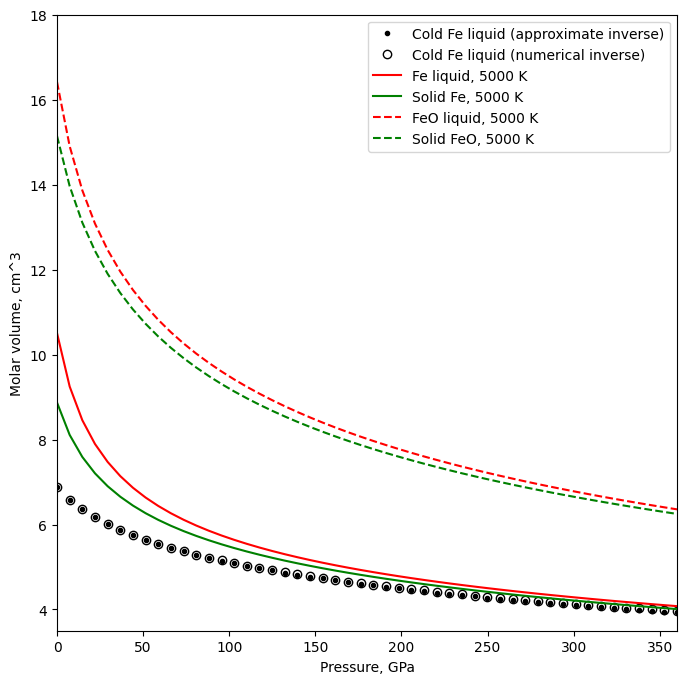

In [4]:
# The plot below looks very like K14 Figure 2 

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ps, v_fe_liquid_298, 'k.', label='Cold Fe liquid (approximate inverse)')
ax.plot(ps, v_fe_liquid_298_num, 'ko', fillstyle='none', label='Cold Fe liquid (numerical inverse)')
ax.plot(ps, v_fe_liquid_hot, 'r', label='Fe liquid, 5000 K')
ax.plot(ps, v_fe_hcp_hot, 'g', label='Solid Fe, 5000 K')
ax.plot(ps, v_feo_liquid_hot, 'r--', label='FeO liquid, 5000 K')
ax.plot(ps, v_feo_solid_hot, 'g--', label='Solid FeO, 5000 K')
ax.set_xlabel('Pressure, GPa')
ax.set_ylabel('Molar volume, cm^3')
ax.legend()
ax.set_ylim([3.5,18.0]) # Match K14, Figure 2
ax.set_xlim([0.0,360.0]) # Match K14, Figure 2

plt.show()

# End member free energy

Steps 1 and 4

In [5]:
gpt = thermodynamic_model.end_member_free_energy(300.0, 5000, feot.fe_liquid_a, feot.fe_liquid_b, feot.fe_liquid_c, 
                                                 feot.fe_liquid_d, feot.fe_liquid_e, feot.fe_liquid_f,
                                                 feot.fe_liquid_v0, feot.fe_liquid_k0, feot.fe_liquid_kp,
                                                 feot.fe_liquid_a0, feot.fe_liquid_ag0, feot.fe_liquid_k)
print('Free energy of liquid Fe at 5000 K and 300 GPa is', gpt/1000.0, 'kJ/mol')


Free energy of liquid Fe at 5000 K and 300 GPa is 1155.3273070106145 kJ/mol


In [6]:
ps = np.linspace(0.0, 350.0)

feo_tms = thermodynamic_model.end_member_melting_temperatures(ps, feot.feo_liquid_a, feot.feo_liquid_b,
                                                              feot.feo_liquid_c, 
                                          feot.feo_liquid_d, feot.feo_liquid_e, feot.feo_liquid_f,
                                          feot.feo_liquid_v0, feot.feo_liquid_k0, feot.feo_liquid_kp,
                                          feot.feo_liquid_a0, feot.feo_liquid_ag0, feot.feo_liquid_k,
                                          feot.feo_solid_a, feot.feo_solid_b, feot.feo_solid_c, 
                                          feot.feo_solid_d, feot.feo_solid_e, feot.feo_solid_f,
                                          feot.feo_solid_v0, feot.feo_solid_k0, feot.feo_solid_kp,
                                          feot.feo_solid_a0, feot.feo_solid_ag0, feot.feo_solid_k)

fe_tms = thermodynamic_model.end_member_melting_temperatures(ps, feot.fe_liquid_a, feot.fe_liquid_b, 
                                                             feot.fe_liquid_c, 
                                          feot.fe_liquid_d, feot.fe_liquid_e, feot.fe_liquid_f,
                                          feot.fe_liquid_v0, feot.fe_liquid_k0, feot.fe_liquid_kp,
                                          feot.fe_liquid_a0, feot.fe_liquid_ag0, feot.fe_liquid_k,
                                          feot.fe_hcp_a, feot.fe_hcp_b, feot.fe_hcp_c, 
                                          feot.fe_hcp_d, feot.fe_hcp_e, feot.fe_hcp_f,
                                          feot.fe_hcp_v0, feot.fe_hcp_k0, feot.fe_hcp_kp,
                                          feot.fe_hcp_a0, feot.fe_hcp_ag0, feot.fe_hcp_k)

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in end_member_melting_temperature (vectorized)
  outputs = ufunc(*inputs)


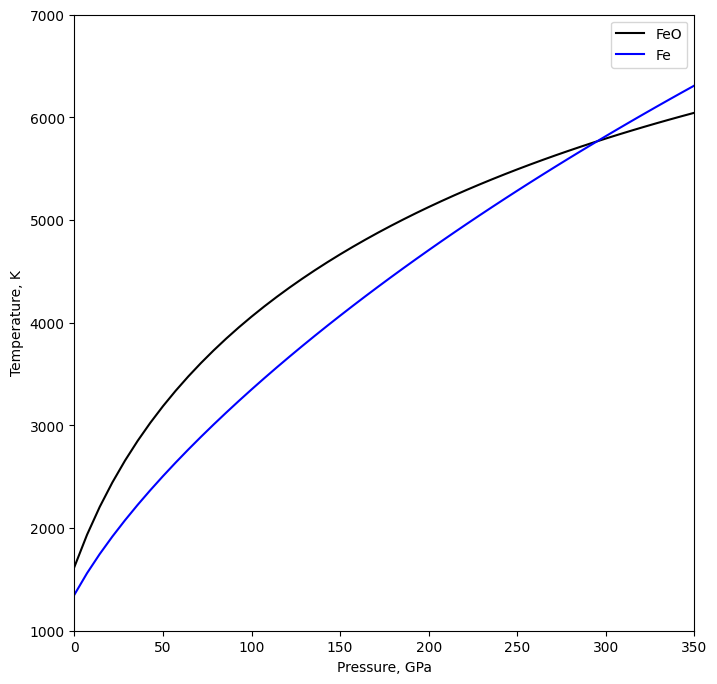

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ps, feo_tms, 'k', label="FeO")
ax.plot(ps, fe_tms , 'b', label="Fe")
ax.set_xlabel('Pressure, GPa')
ax.set_ylabel('Temperature, K')
ax.set_ylim([1000.0,7000.0]) 
ax.set_xlim([0.0,350.0])
ax.legend()

plt.show()

## Ideal solution

Step 6 (for liquid)

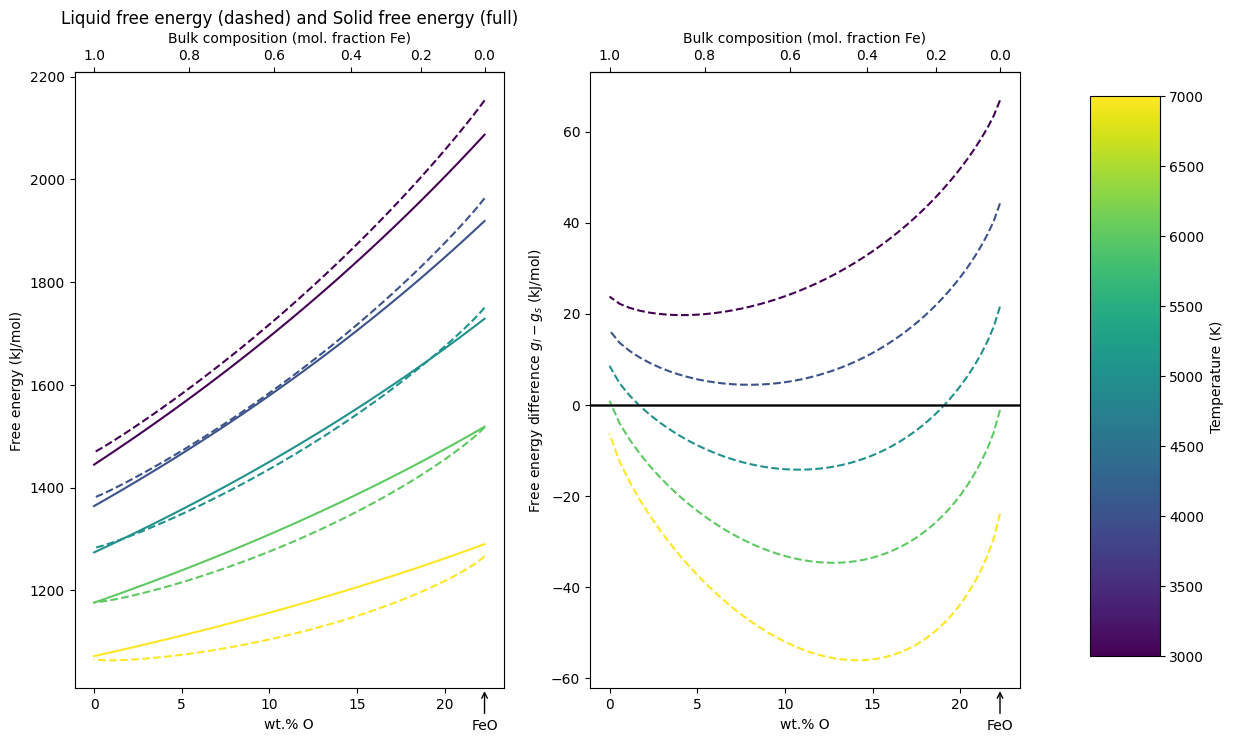

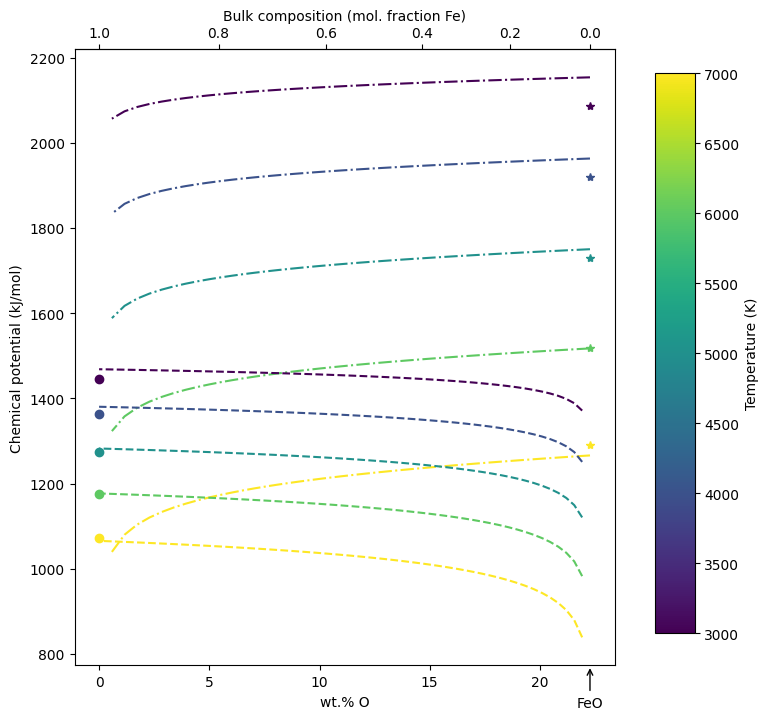

In [8]:
p = 330.0
x_l = np.linspace(0.0, 1.0)
ts = [7000.0, 6000.0, 5000.0, 4000.0, 3000.0]
g_l = []
g_feo = []
g_fe = []
g_solid_mixture = []
mu_fe_l = []
mu_feo_l = []
for t in ts:
    g_l.append(feot.liquid_free_energies(x_l, p, t))
    g_mixture_t, g_fe_t, g_feo_t = feot.solid_free_energies(x_l, p, t)
    g_feo.append(g_feo_t)
    g_fe.append(g_fe_t)
    g_solid_mixture.append(g_mixture_t)
    mu_fe_l.append(feot.fe_liquid_chemical_potential(x_l[1:], p, t))   
    mu_feo_l.append(feot.feo_liquid_chemical_potential(x_l[:-1], p, t))

# mu's already calculated in liquid_free_energy; last 2 calls for plotting only

########################################################################################

fig, axs = plt.subplots(figsize=(14,8), ncols=2)
cmap=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap.set_clim(vmin=min(ts), vmax=max(ts))

for ii, t in enumerate(ts):
    axs[0].plot(feot.mass_percent_o(x_l), g_l[ii]/1000, '--', color=cmap.to_rgba(t))
    axs[0].plot(feot.mass_percent_o(x_l), g_solid_mixture[ii]/1000, '-', color=cmap.to_rgba(t))
    
    axs[1].plot(feot.mass_percent_o(x_l), (g_l[ii] - g_solid_mixture[ii])/1000, '--', color=cmap.to_rgba(t))
    axs[1].axhline(color='k', lw=1)
    
axs[0].set_title("Liquid free energy (dashed) and Solid free energy (full)")
axs[0].set_xlabel('wt.% O')
axs[0].set_ylabel('Free energy (kJ/mol)')

secax = axs[0].secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax.set_xlabel('Bulk composition (mol. fraction Fe)')

axs[0].annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -30.0), 
            xycoords=axs[0].get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'))

axs[1].set_xlabel('wt.% O')
axs[1].set_ylabel('Free energy difference $g_l-g_s$ (kJ/mol)')


secax = axs[1].secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax.set_xlabel('Bulk composition (mol. fraction Fe)')

axs[1].annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -30.0), 
            xycoords=axs[1].get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Temperature (K)')
plt.show()


########################################################################################


fig, ax = plt.subplots(figsize=(8,8))
cmap=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap.set_clim(vmin=min(ts), vmax=max(ts))

for ii, t in enumerate(ts):
    ax.plot(feot.mass_percent_o(x_l[1:]), mu_fe_l[ii]/1000, '--', color=cmap.to_rgba(t))
    ax.plot(feot.mass_percent_o(1.0), g_fe[ii]/1000, 'o', color=cmap.to_rgba(t))
    ax.plot(feot.mass_percent_o(x_l[:-1]), mu_feo_l[ii]/1000, '-.', color=cmap.to_rgba(t))
    ax.plot(feot.mass_percent_o(0.0), g_feo[ii]/1000, '*', color=cmap.to_rgba(t))
    
ax.set_xlabel('wt.% O')
ax.set_ylabel('Chemical potential (kJ/mol)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Temperature (K)')

secax = ax.secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax.set_xlabel('Bulk composition (mol. fraction Fe)')

ax.annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -30.0), 
            xycoords=ax.get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'))

plt.show()

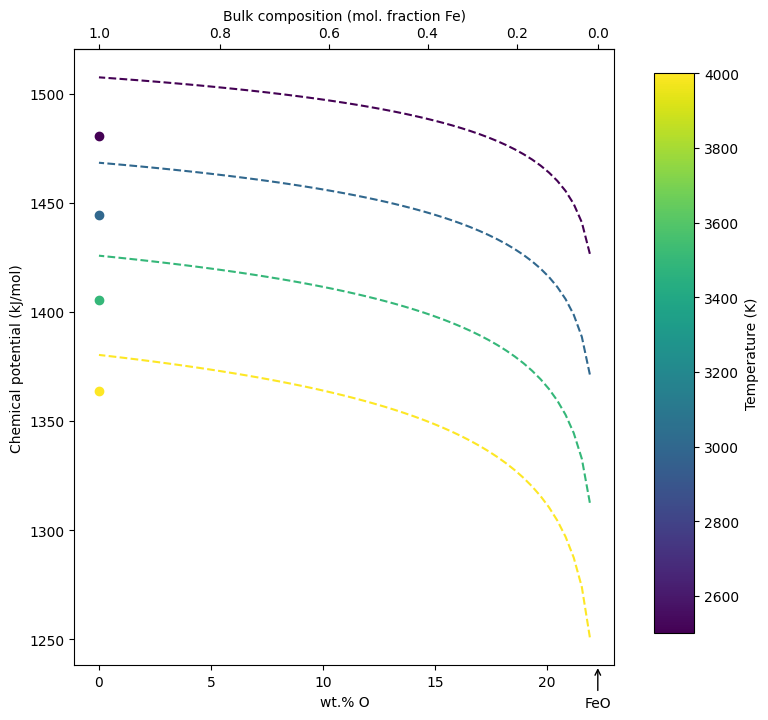

In [9]:
# Slide for AMW's nuc talk.

p = 330.0
x_l = np.linspace(0.0, 1.0)
ts = [4000.0, 3500.0, 3000.0, 2500.0]
g_l = []
g_feo = []
g_fe = []
g_solid_mixture = []
mu_fe_l = []
mu_feo_l = []
for t in ts:
    g_l.append(feot.liquid_free_energies(x_l, p, t))
    g_mixture_t, g_fe_t, g_feo_t = feot.solid_free_energies(x_l, p, t)
    g_feo.append(g_feo_t)
    g_fe.append(g_fe_t)
    g_solid_mixture.append(g_mixture_t)
    mu_fe_l.append(feot.fe_liquid_chemical_potential(x_l[1:], p, t))   
    mu_feo_l.append(feot.feo_liquid_chemical_potential(x_l[:-1], p, t))



fig, ax = plt.subplots(figsize=(8,8))
cmap=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap.set_clim(vmin=min(ts), vmax=max(ts))

for ii, t in enumerate(ts):
    ax.plot(feot.mass_percent_o(x_l[1:]), mu_fe_l[ii]/1000, '--', color=cmap.to_rgba(t))
    ax.plot(feot.mass_percent_o(1.0), g_fe[ii]/1000, 'o', color=cmap.to_rgba(t))
    
ax.set_xlabel('wt.% O')
ax.set_ylabel('Chemical potential (kJ/mol)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Temperature (K)')

secax = ax.secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax.set_xlabel('Bulk composition (mol. fraction Fe)')

ax.annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -30.0), 
            xycoords=ax.get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'))

plt.show()

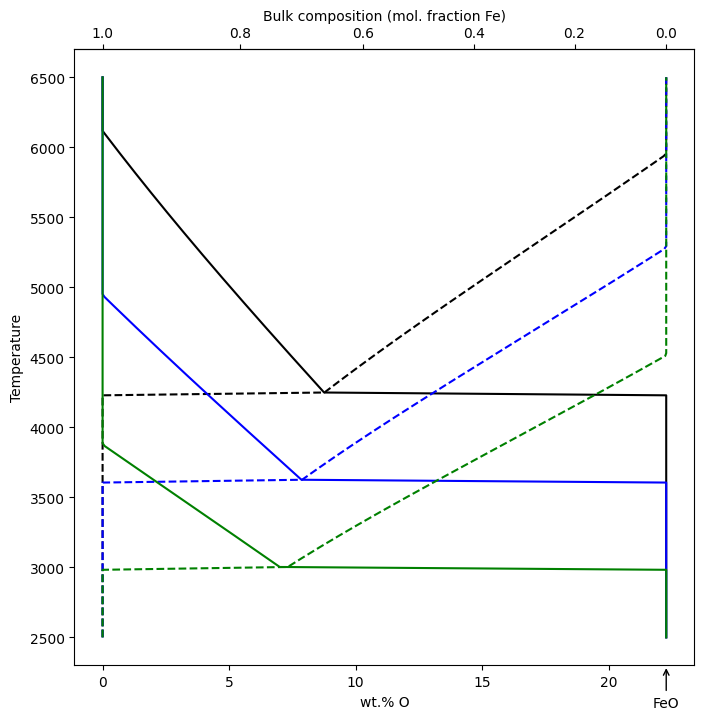

In [10]:
p1 = 330.0
p2 = 220.0
p3 = 136.0
ts = np.linspace(2500, 6500, 200)
x11 = np.zeros_like(ts)
x21 = np.zeros_like(ts)
x12 = np.zeros_like(ts)
x22 = np.zeros_like(ts)
x13 = np.zeros_like(ts)
x23 = np.zeros_like(ts)

# In current implementation (07/04/2021) use find_liquidus_compositions
for i, t in enumerate(ts):
    x11[i], x21[i] = feot.find_liquidus_compositions(p1, t)
    x12[i], x22[i] = feot.find_liquidus_compositions(p2, t)
    x13[i], x23[i] = feot.find_liquidus_compositions(p3, t)
    
fig, ax = plt.subplots(figsize=(8,8))
# flip Fe-FeO direction for plot
ax.plot(feot.mass_percent_o(x11), ts, 'k')
ax.plot(feot.mass_percent_o(x21), ts, 'k--')

ax.plot(feot.mass_percent_o(x12), ts, 'b')
ax.plot(feot.mass_percent_o(x22), ts, 'b--')

ax.plot(feot.mass_percent_o(x13), ts, 'g')
ax.plot(feot.mass_percent_o(x23), ts, 'g--')

ax.set_xlabel('wt.% O')
ax.set_ylabel('Temperature')

secax = ax.secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax.set_xlabel('Bulk composition (mol. fraction Fe)')

ax.annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -30.0), 
            xycoords=ax.get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'))


plt.show()

In [11]:
x = np.array([0.0, 0.2, 0.4, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0])
p = 330.0
# Warning - doing it this way around is super slow
# and a bit clunky near the eutectic
# See comment above. 
tl = feot.find_liquidus(x, p)

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in end_member_melting_temperature (vectorized)
  outputs = ufunc(*inputs)
/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


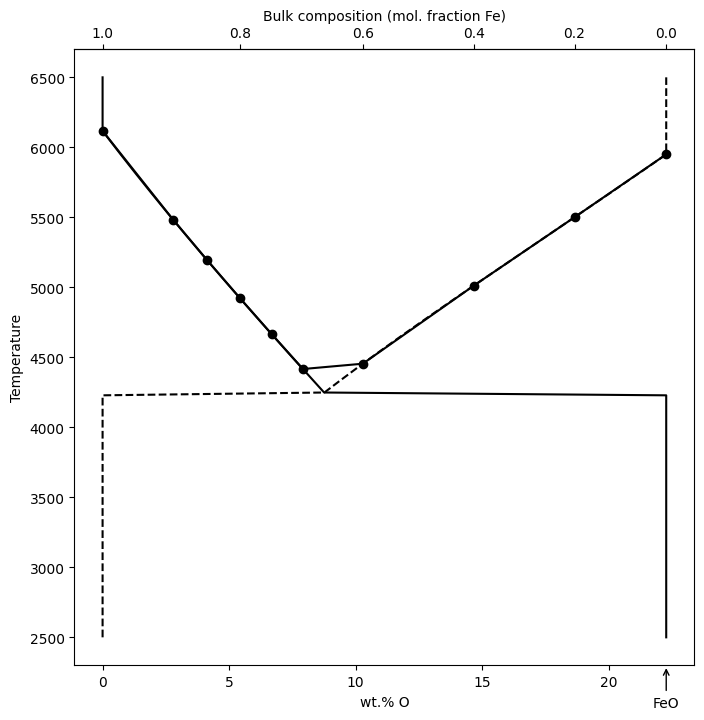

In [12]:
# find_liquidus does not have a point at the eutectic. 
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(feot.mass_percent_o(x), tl, 'ko')
ax.plot(feot.mass_percent_o(x), tl, 'k-')
ax.plot(feot.mass_percent_o(x11), ts, 'k')
ax.plot(feot.mass_percent_o(x21), ts, 'k--')
ax.set_xlabel('wt.% O')
ax.set_ylabel('Temperature')

secax = ax.secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax.set_xlabel('Bulk composition (mol. fraction Fe)')

ax.annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -30.0), 
            xycoords=ax.get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'))


plt.show()

In [13]:
x = 0.98
p = 330

for t in [6500, 6000, 5000, 4500, 4400, 4300]:
    x_lq, phi_fe, phi_lq, phi_feo, phi_solid = \
        feot.phase_relations_molar(x, p, t)
    print("Temperature:", t, "K, bulk FeO mol frac:", 1.0-x, "pressure:", p, "GPa")
    print("Mol frac solid Fe:", phi_fe)
    print("Mol frac solid FeO:", phi_feo)
    print("Mol frac liquid:", phi_lq)
    print("FeO mol. frac in liquid:", 1.0-x_lq)
    print("Volume fraction solid:", feot.volume_fraction_solid(x, p, t))

    print()

Temperature: 6500 K, bulk FeO mol frac: 0.020000000000000018 pressure: 330 GPa
Mol frac solid Fe: 0.0
Mol frac solid FeO: 0.0
Mol frac liquid: 1.0
FeO mol. frac in liquid: 0.020000000000000018
Volume fraction solid: 0.0

Temperature: 6000 K, bulk FeO mol frac: 0.020000000000000018 pressure: 330 GPa
Mol frac solid Fe: 0.0
Mol frac solid FeO: 0.0
Mol frac liquid: 1.0
FeO mol. frac in liquid: 0.020000000000000018
Volume fraction solid: 0.0

Temperature: 5000 K, bulk FeO mol frac: 0.020000000000000018 pressure: 330 GPa
Mol frac solid Fe: 0.892372264677599
Mol frac solid FeO: 0.0
Mol frac liquid: 0.10762773532240102
FeO mol. frac in liquid: 0.18582570691550482
Volume fraction solid: 0.8895722559827696

Temperature: 4500 K, bulk FeO mol frac: 0.020000000000000018 pressure: 330 GPa
Mol frac solid Fe: 0.9293213783072919
Mol frac solid FeO: 0.0
Mol frac liquid: 0.07067862169270812
FeO mol. frac in liquid: 0.28297099633542244
Volume fraction solid: 0.9274005571929438

Temperature: 4400 K, bulk F

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


In [14]:
ts, xs = np.meshgrid(np.linspace(4000, 6500, 50),
                     np.linspace(0.0, 1.0, 50))

x_lq, phi_fe, phi_lq, phi_feo, phi_solid = feot.phase_relations_molar(xs, 330, ts)

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


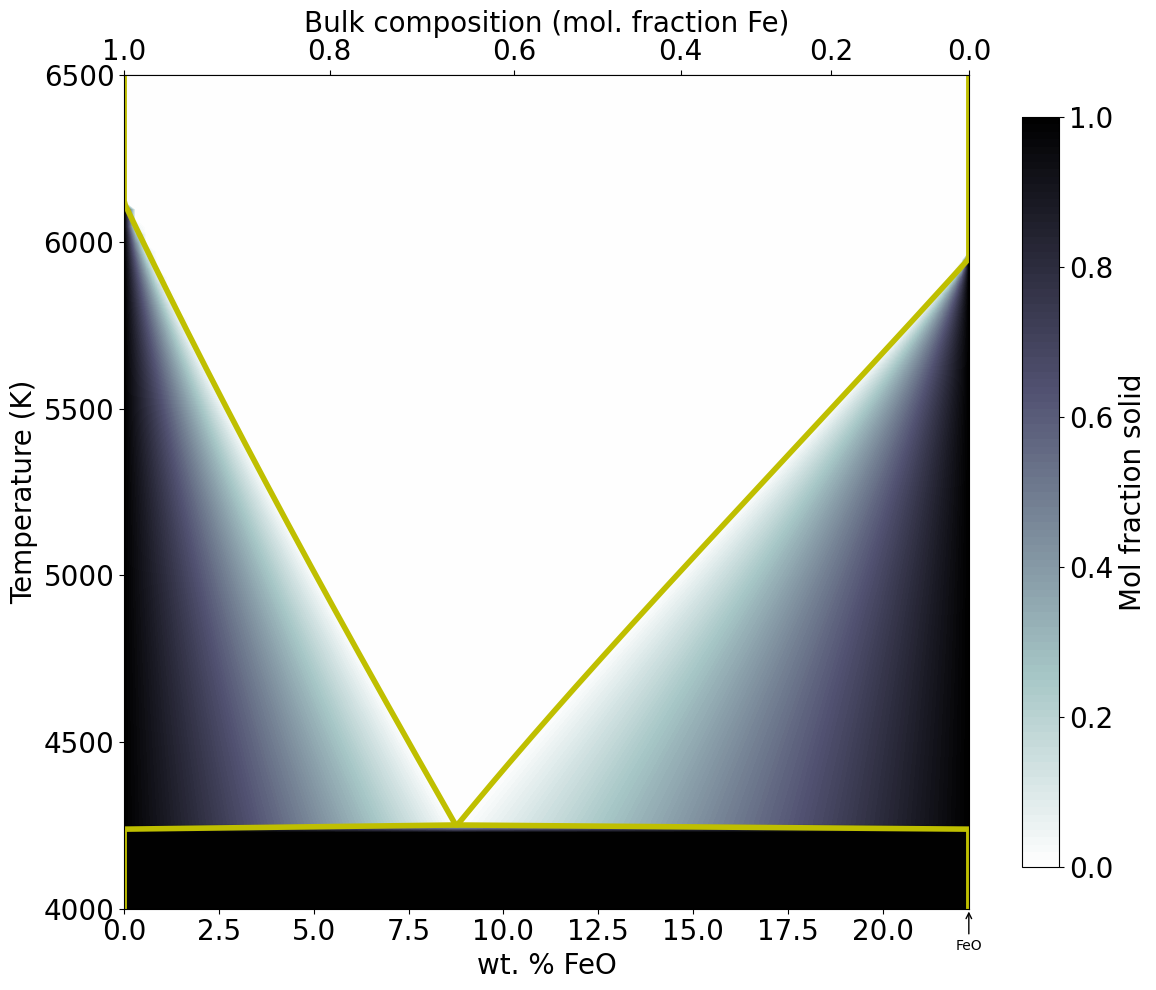

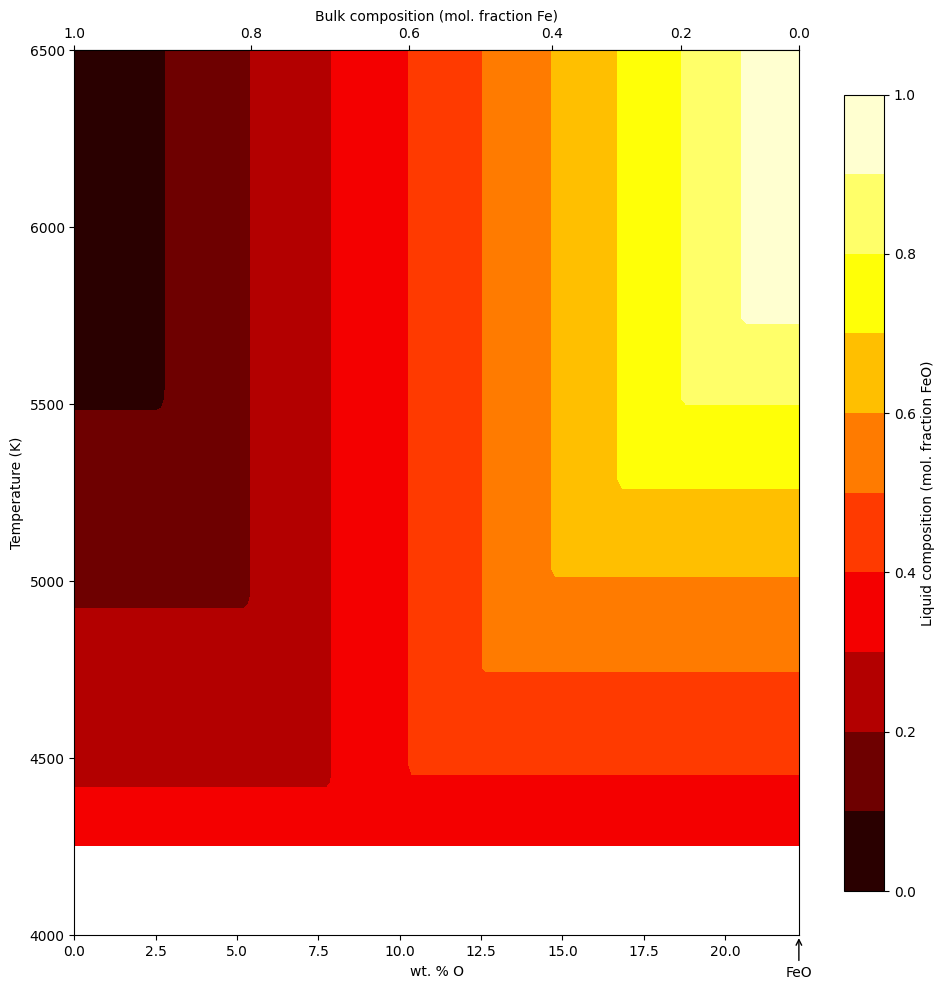

In [15]:
ts, xs = np.meshgrid(np.linspace(4000, 6500, 100),
                     np.linspace(0.0, 1.0, 100))
x_lq, phi_fe, phi_lq, phi_feo, phi_solid = feot.phase_relations_molar(xs, 330, ts)

t_list = np.linspace(4000, 6500, 200)
x_left_list = np.zeros_like(t_list)
x_right_list = np.zeros_like(t_list)
for i, t in enumerate(t_list):
    x_left_list[i], x_right_list[i] = feot.find_liquidus_compositions(330, t)

fig, ax = plt.subplots(figsize=(12,10))
h = ax.contourf(feot.mass_percent_o(xs), ts, phi_solid, 
                   cmap=plt.cm.bone_r,
                   levels=101)
cbar = fig.colorbar(h, ax=ax, shrink=0.9, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax.plot(feot.mass_percent_o(x_left_list), t_list, 'y', lw=4)
ax.plot(feot.mass_percent_o(x_right_list), t_list, 'y', lw=4)

#ax.set_title("Komabayashi (2014), P = 330 GPa")
cbar.ax.set_ylabel("Mol fraction solid")
ax.set_ylabel("Temperature (K)")
ax.set_xlabel("wt. % FeO")

secax = ax.secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax.set_xlabel('Bulk composition (mol. fraction Fe)')

ax.annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -30.0), 
            xycoords=ax.get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'))


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, secax.xaxis.label, cbar.ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + secax.get_xticklabels() + cbar.ax.get_yticklabels() ):
    item.set_fontsize(20)
    
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
h = ax.contourf(feot.mass_percent_o(xs), ts, 1.0-x_lq, 
                   cmap=plt.cm.hot,
                  levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar = fig.colorbar(h, ax=ax, shrink=0.9)

cbar.ax.set_ylabel("Liquid composition (mol. fraction FeO)")
ax.set_ylabel("Temperature (K)")
ax.set_xlabel("wt. % O")

secax = ax.secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax.set_xlabel('Bulk composition (mol. fraction Fe)')

ax.annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -30.0), 
            xycoords=ax.get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'))

plt.tight_layout()
plt.show()

In [16]:
x = np.linspace(0.0, 1.0)
p = 330.0
t = 5000.0
liquid_density, solid_mixture_density, fe_liquid_density, fe_hpc_density, \
           feo_liquid_density, feo_solid_density = feot.densities(x, p, t)

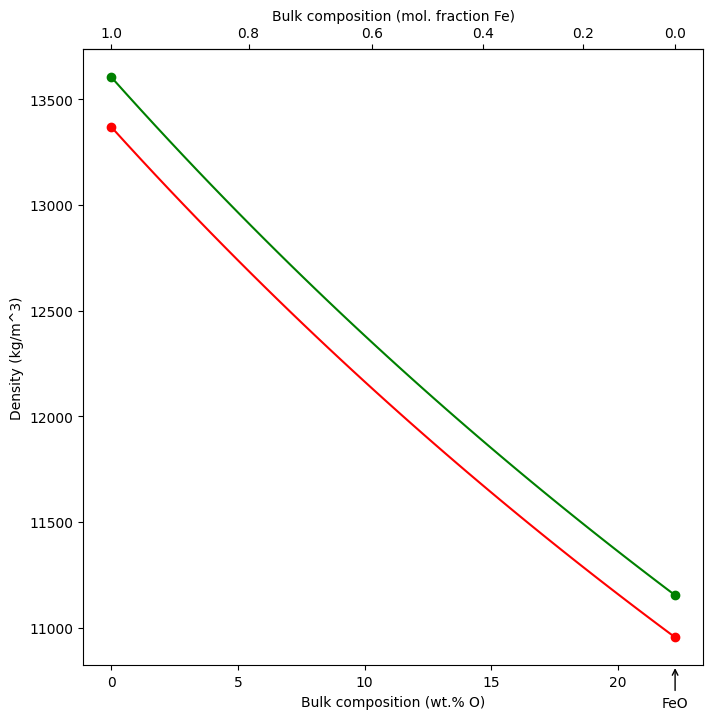

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
# flip Fe-FeO direction for plot
ax.plot(feot.mass_percent_o(x), liquid_density, 'r-')
ax.plot(feot.mass_percent_o(x), solid_mixture_density, 'g-')

ax.plot(feot.mass_percent_o(1), fe_liquid_density[0], 'ro')
ax.plot(feot.mass_percent_o(0), feo_liquid_density[0], 'ro')

ax.plot(feot.mass_percent_o(1), fe_hpc_density[0], 'go')
ax.plot(feot.mass_percent_o(0), feo_solid_density[0], 'go')

ax.set_xlabel('Bulk composition (wt.% O)')
ax.set_ylabel('Density (kg/m^3)')

secax = ax.secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax.set_xlabel('Bulk composition (mol. fraction Fe)')

ax.annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -30.0), 
            xycoords=ax.get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'))

plt.show()

## Figure for paper...

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in phase_relations_molar (vectorized)
  outputs = ufunc(*inputs)


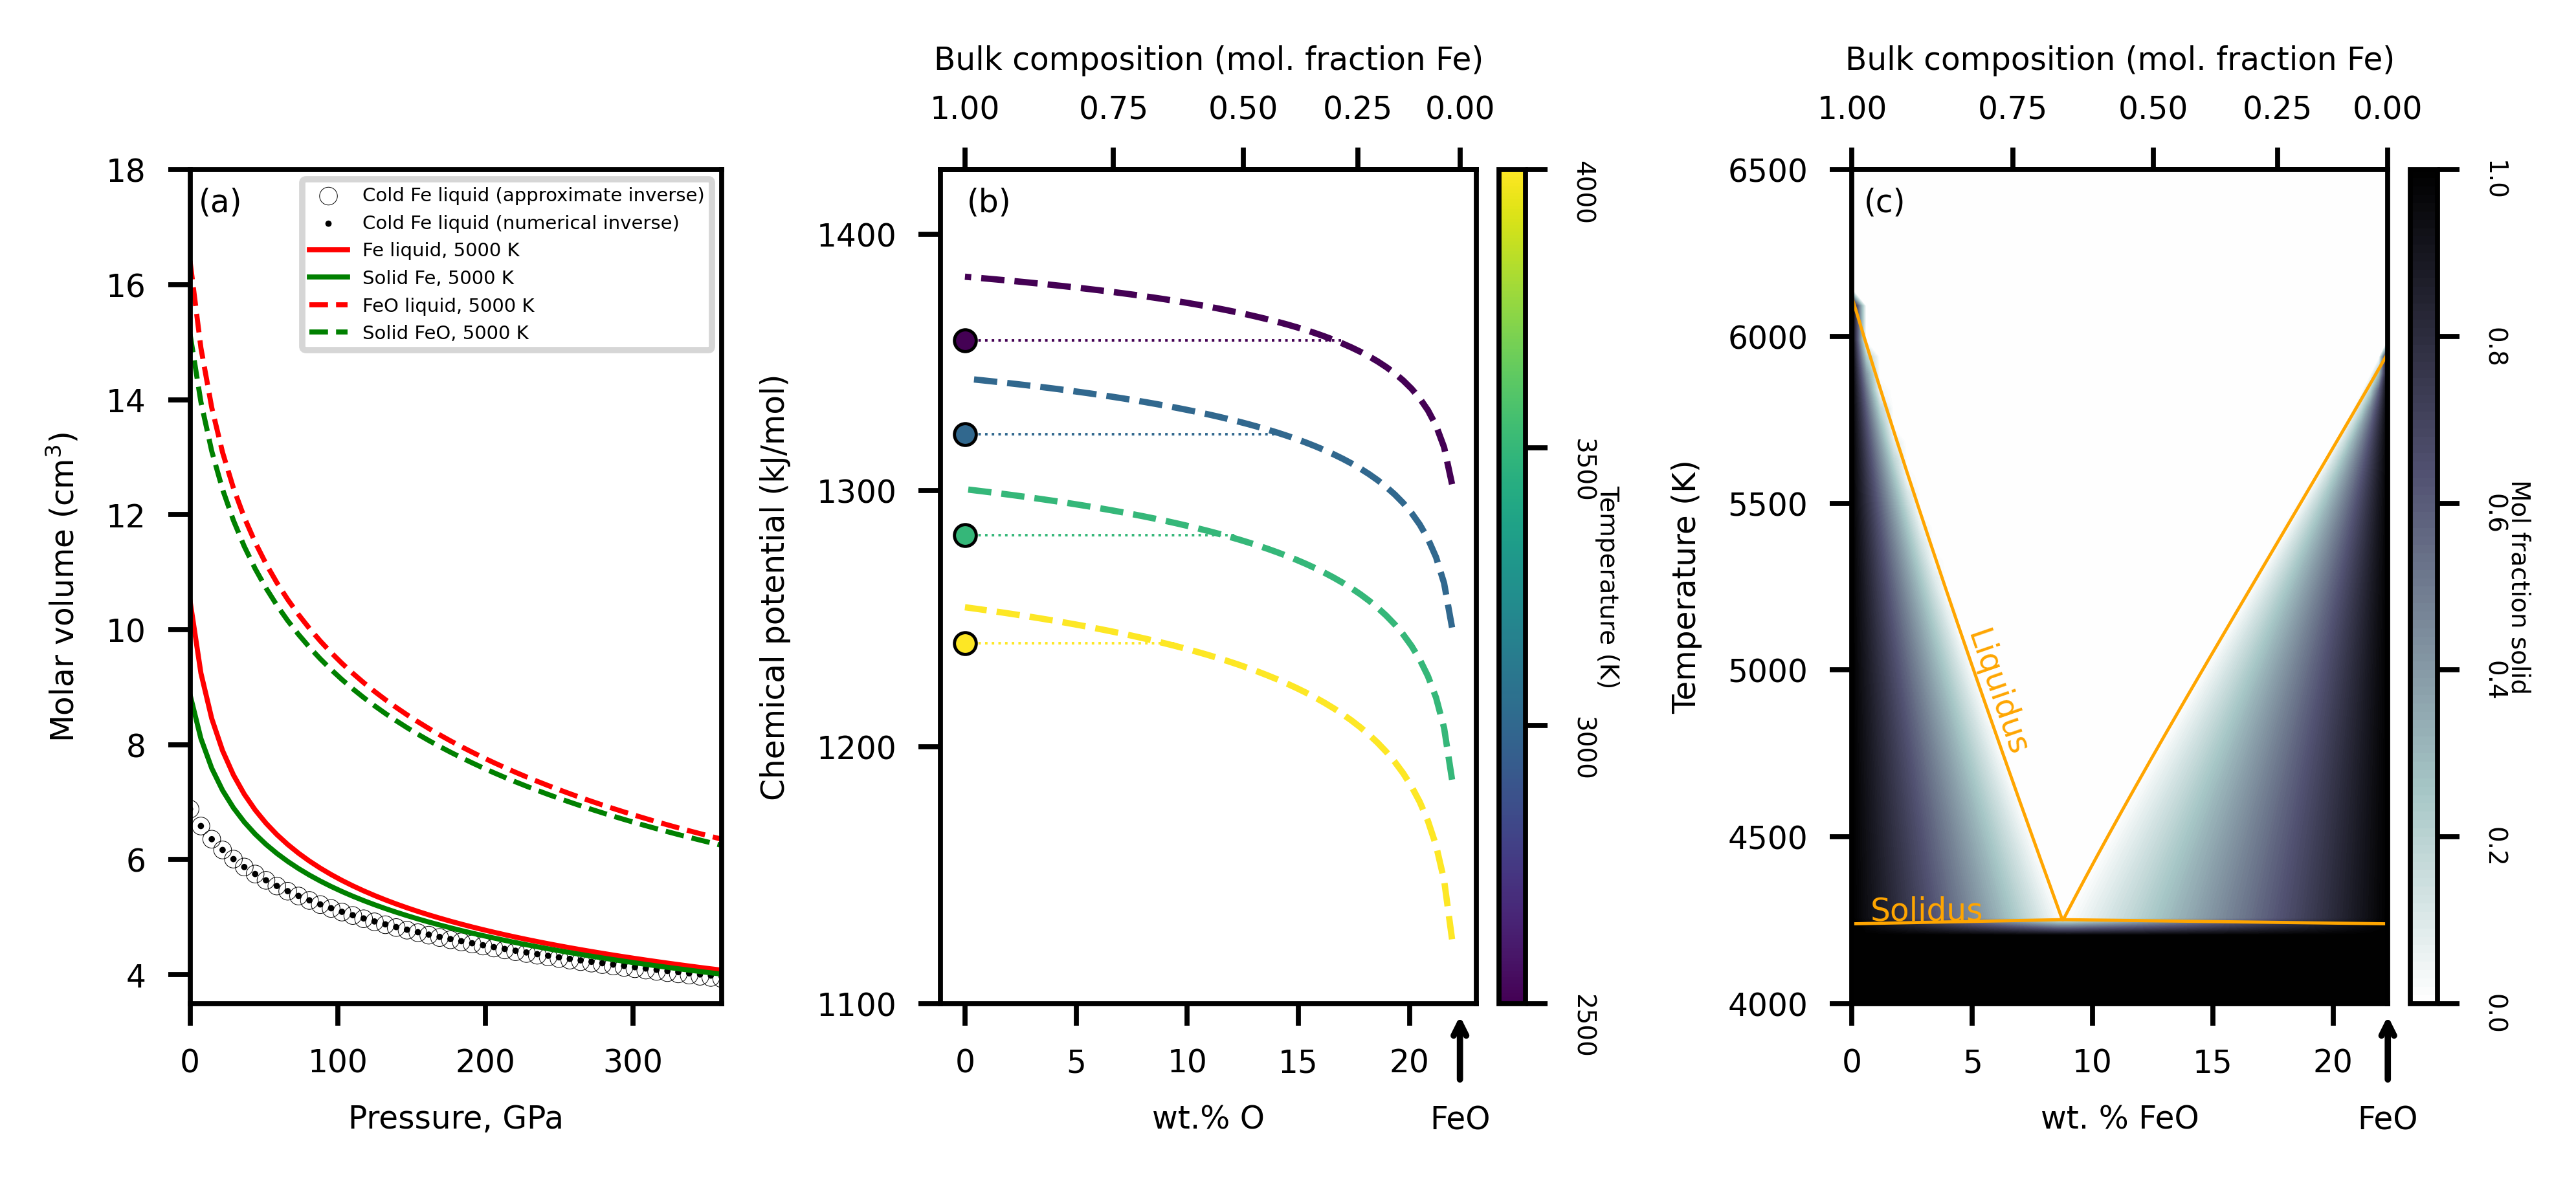

In [18]:
fig = plt.figure(dpi=700)

w0 = 20
w12 = 22
gap01 = 8
gap12 = 12
vh = 10
vgap = 2
ax0 = plt.subplot2grid((vh, w0+gap01+w12+gap12+w12), (0, 0), colspan=w0,rowspan=vh-vgap)
ax1 = plt.subplot2grid((vh, w0+gap01+w12+gap12+w12), (0, w0+gap01), colspan=w12,rowspan=vh-vgap)
ax2 = plt.subplot2grid((vh, w0+gap01+w12+gap12+w12), (0, w0+gap01+w12+gap12), colspan=w12,rowspan=vh-vgap)

fntsz = 5
cbfntsz = 4
lgfntsz = 3

# Volumes of liquid Fe at 298 K
ps = np.linspace(0.0, 360.0)
v_fe_liquid_298 = thermodynamic_model.vinet_eos_volumes(ps, feot.fe_liquid_v0, feot.fe_liquid_k0, feot.fe_liquid_kp)
v_fe_liquid_298_num = thermodynamic_model.numerical_vinet_eos_volumes(ps, feot.fe_liquid_v0, feot.fe_liquid_k0, feot.fe_liquid_kp)

t = 5000.0

v_fe_liquid_hot  = thermodynamic_model.expand_volume(v_fe_liquid_298, t, feot.fe_liquid_v0, feot.fe_liquid_a0, 
                                                    feot.fe_liquid_ag0, feot.fe_liquid_k)
v_fe_hcp_hot     = thermodynamic_model.expand_volume(
    thermodynamic_model.vinet_eos_volumes(ps, feot.fe_hcp_v0      , feot.fe_hcp_k0    , feot.fe_hcp_kp),
    t, feot.fe_hcp_v0    , feot.fe_hcp_a0    , feot.fe_hcp_ag0    , feot.fe_hcp_k)
v_feo_solid_hot  = thermodynamic_model.expand_volume(
    thermodynamic_model.vinet_eos_volumes(ps, feot.feo_solid_v0   , feot.feo_solid_k0 , feot.feo_solid_kp),
    t, feot.feo_solid_v0 , feot.feo_solid_a0 , feot.feo_solid_ag0 , feot.feo_solid_k)
v_feo_liquid_hot = thermodynamic_model.expand_volume(
    thermodynamic_model.vinet_eos_volumes(ps, feot.feo_liquid_v0  , feot.feo_liquid_k0, feot.feo_liquid_kp), 
    t, feot.feo_liquid_v0, feot.feo_liquid_a0, feot.feo_liquid_ag0, feot.feo_liquid_k)

ts = [7000.0, 6000.0, 5000.0, 4000.0, 3000.0]

ax0.scatter(ps, v_fe_liquid_298, marker='o', label='Cold Fe liquid (approximate inverse)',s=8,edgecolor='black',linewidth=0.1,facecolors='none',)
ax0.scatter(ps, v_fe_liquid_298_num, marker='o', label='Cold Fe liquid (numerical inverse)',s=1,facecolors='black',edgecolor='none')
ax0.plot(ps, v_fe_liquid_hot, 'r', label='Fe liquid, 5000 K',linewidth=0.8)
ax0.plot(ps, v_fe_hcp_hot, 'g', label='Solid Fe, 5000 K',linewidth=0.8)
ax0.plot(ps, v_feo_liquid_hot, 'r--', label='FeO liquid, 5000 K',linewidth=0.8)
ax0.plot(ps, v_feo_solid_hot, 'g--', label='Solid FeO, 5000 K',linewidth=0.8)
ax0.set_xlabel('Pressure, GPa',fontsize=fntsz)
ax0.set_ylabel('Molar volume (cm$^3$)',fontsize=fntsz)
ax0.legend(fontsize=lgfntsz)
ax0.set_ylim([3.5,18.0]) # Match K14, Figure 2
ax0.set_xlim([0.0,360.0]) # Match K14, Figure 2

##########################################################################################

p = 300.0
x_l = np.linspace(0.0, 1.0)
ts = [4000.0, 3500.0, 3000.0, 2500.0]
g_l = []
g_feo = []
g_fe = []
g_solid_mixture = []
mu_fe_l = []
mu_feo_l = []

for t in ts:
    g_l.append(feot.liquid_free_energies(x_l, p, t))
    g_mixture_t, g_fe_t, g_feo_t = feot.solid_free_energies(x_l, p, t)
    g_feo.append(g_feo_t)
    g_fe.append(g_fe_t)
    g_solid_mixture.append(g_mixture_t)
    mu_fe_l.append(feot.fe_liquid_chemical_potential(x_l[1:], p, t))   
    mu_feo_l.append(feot.feo_liquid_chemical_potential(x_l[:-1], p, t))

cmap1=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap1.set_clim(vmin=min(ts), vmax=max(ts))

for ii, t in enumerate(ts):
    ax1.plot(feot.mass_percent_o(x_l[1:]), mu_fe_l[ii]/1000, '--', color=cmap1.to_rgba(t),linewidth=1,zorder=2)
    ax1.scatter(feot.mass_percent_o(1.0), g_fe[ii]/1000, marker='o', color=cmap1.to_rgba(t),edgecolor='black',s=12,linewidth=0.5,zorder=3)
    x2 = feot.mass_percent_o(x_l[min(range(len((mu_fe_l[ii]-g_fe[2])**2.)), key=((mu_fe_l[ii]-g_fe[ii])**2.).__getitem__)])
    ax1.plot([feot.mass_percent_o(1.0),x2], [g_fe[ii]/1000,g_fe[ii]/1000],color=cmap1.to_rgba(t),linestyle='dotted',zorder=1,linewidth=0.4)
    
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(cmap1, cax=cax1, shrink=0.9, ticks=[2500,3000,3500,4000])
cbar1.set_label('Temperature (K)',fontsize=cbfntsz,rotation=270)
cbar1.ax.tick_params(labelsize=cbfntsz,rotation=270) 

ax1.set_xlabel('wt.% O',fontsize=fntsz)
ax1.set_ylabel('Chemical potential (kJ/mol)',fontsize=fntsz)
ax1.set_ylim(1100,1425)
ax1.set_yticks([1100,1200,1300,1400])

secax1 = ax1.secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax1.set_xlabel('Bulk composition (mol. fraction Fe)',fontsize=fntsz)

ax1.annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -20.0), 
            xycoords=ax1.get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'),fontsize=fntsz)

##########################################################################################

ts, xs = np.meshgrid(np.linspace(4000, 6500, 50),np.linspace(0.0, 1.0, 50))
x_lq, phi_fe, phi_lq, phi_feo, phi_solid = feot.phase_relations_molar(xs, 330, ts)

cmap2 = ax2.contourf(feot.mass_percent_o(xs), ts, phi_solid, 
                   cmap=plt.cm.bone_r,
                   levels=101)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(cmap2, cax=cax2, shrink=0.9, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar2.ax.set_ylabel("Mol fraction solid",fontsize=cbfntsz,rotation=270)
cbar2.ax.tick_params(labelsize=cbfntsz,rotation=270)

ax2.plot(feot.mass_percent_o(x_left_list), t_list, color='orange', lw=0.5)
ax2.plot(feot.mass_percent_o(x_right_list), t_list, color='orange', lw=0.5)

ax2.set_ylabel("Temperature (K)",fontsize=fntsz)
ax2.set_xlabel("wt. % FeO",fontsize=fntsz)

secax2 = ax2.secondary_xaxis('top', functions=(feot.mol_frac_fe, feot.mass_percent_o))
secax2.set_xlabel("Bulk composition (mol. fraction Fe)",fontsize=fntsz)

ax2.annotate('FeO', xy=(feot.mass_percent_o(0), 0.0), xytext=(0.0, -20.0), 
            xycoords=ax2.get_xaxis_transform(),
            color='k', ha='center', textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle="arc3", color='k'),fontsize=fntsz)
ax2.annotate('Solidus', xy=(3.1,0.1), 
            xycoords=ax2.get_xaxis_transform(),
            color='orange', ha='center', 
            fontsize=fntsz)
ax2.annotate('Liquidus', xy=(6,0.3), 
            xycoords=ax2.get_xaxis_transform(),
            color='orange', ha='center', 
            fontsize=fntsz,rotation=-71)

ax0.annotate('(a)', xy=(6,0.95),xycoords=ax0.get_xaxis_transform(),fontsize=fntsz)
ax1.annotate('(b)', xy=(0.1,0.95),xycoords=ax1.get_xaxis_transform(),fontsize=fntsz)
ax2.annotate('(c)', xy=(0.5,0.95),xycoords=ax2.get_xaxis_transform(),fontsize=fntsz)


for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label, secax2.xaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels() + secax2.get_xticklabels() ):
    item.set_fontsize(fntsz)
    
ax0.tick_params(axis='both', labelsize=fntsz)
ax1.tick_params(axis='both', labelsize=fntsz)
ax2.tick_params(axis='both', labelsize=fntsz)
secax1.tick_params(axis='both', labelsize=fntsz)
secax2.tick_params(axis='both', labelsize=fntsz)


fig.set_figheight(3)
plt.savefig('Fig1_triple.jpg')
plt.show()